In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# ## Shoe Classification Project
# ### Import Required Libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from sklearn.model_selection import ParameterGrid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
import os


In [ ]:
# ### Data Preprocessing and Augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
# ### Load Dataset with Custom Paths
train_dir = '/content/drive/MyDrive/Nike_Adidas_converse_Shoes_image_dataset/train'
val_dir = '/content/drive/MyDrive/Nike_Adidas_converse_Shoes_image_dataset/validate'

image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val'])
}

dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes confirmed: {class_names}")
print(f"Training images: {dataset_sizes['train']} (200 per class expected)")
print(f"Validation images: {dataset_sizes['val']} (30 per class expected)")

Classes confirmed: ['adidas', 'converse', 'nike']
Training images: 603 (200 per class expected)
Validation images: 90 (30 per class expected)


In [ ]:
# ### Enhanced Model Configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pretrained EfficientNet
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[1].in_features

# Modified classifier
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(),
    nn.Linear(256, len(class_names))
)
model = model.to(device)

# Optimizer and scheduler with correct step count
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Calculate total steps explicitly
num_epochs = 20
steps_per_epoch = len(dataloaders['train'])
total_steps = steps_per_epoch * num_epochs

scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    total_steps=total_steps
)

In [ ]:
# ### Training Execution
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    best_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Training phase
        model.train()
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            _, preds = torch.max(outputs, 1)
            epoch_train_loss += loss.item() * inputs.size(0)
            epoch_train_acc += torch.sum(preds == labels.data)

        # Validation phase
        model.eval()
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                epoch_val_loss += loss.item() * inputs.size(0)
                epoch_val_acc += torch.sum(preds == labels.data)

        # Calculate epoch metrics
        train_loss = epoch_train_loss / dataset_sizes['train']
        train_acc = epoch_train_acc.double() / dataset_sizes['train']
        val_loss = epoch_val_loss / dataset_sizes['val']
        val_acc = epoch_val_acc.double() / dataset_sizes['val']

        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')

    return model, train_losses, train_accs, val_losses, val_accs

# Start training
model, train_losses, train_accs, val_losses, val_accs = train_model(
    model, criterion, optimizer, scheduler, num_epochs=20
)

Epoch 1/20
Train Loss: 1.0909 Acc: 0.3947
Val Loss: 1.0639 Acc: 0.4889

Epoch 2/20
Train Loss: 1.0028 Acc: 0.6368
Val Loss: 0.8017 Acc: 0.7667

Epoch 3/20
Train Loss: 0.6839 Acc: 0.7479
Val Loss: 0.4040 Acc: 0.8111

Epoch 4/20
Train Loss: 0.4916 Acc: 0.7944
Val Loss: 0.4471 Acc: 0.8556

Epoch 5/20
Train Loss: 0.4395 Acc: 0.8425
Val Loss: 0.5538 Acc: 0.8111

Epoch 6/20
Train Loss: 0.4699 Acc: 0.8060
Val Loss: 0.4632 Acc: 0.8778

Epoch 7/20
Train Loss: 0.3573 Acc: 0.8624
Val Loss: 0.5904 Acc: 0.8333

Epoch 8/20
Train Loss: 0.4118 Acc: 0.8458
Val Loss: 0.3700 Acc: 0.9000

Epoch 9/20
Train Loss: 0.3553 Acc: 0.8640
Val Loss: 0.3219 Acc: 0.9111

Epoch 10/20
Train Loss: 0.3647 Acc: 0.8640
Val Loss: 0.4190 Acc: 0.8556

Epoch 11/20
Train Loss: 0.2382 Acc: 0.9138
Val Loss: 0.3656 Acc: 0.8889

Epoch 12/20
Train Loss: 0.2414 Acc: 0.8955
Val Loss: 0.4133 Acc: 0.9222

Epoch 13/20
Train Loss: 0.2174 Acc: 0.9154
Val Loss: 0.3825 Acc: 0.9111

Epoch 14/20
Train Loss: 0.2158 Acc: 0.9221
Val Loss: 0.3456 

In [ ]:
# ### Final Evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'\nFinal Validation Accuracy: {100 * correct / total:.2f}%')


Final Validation Accuracy: 92.22%


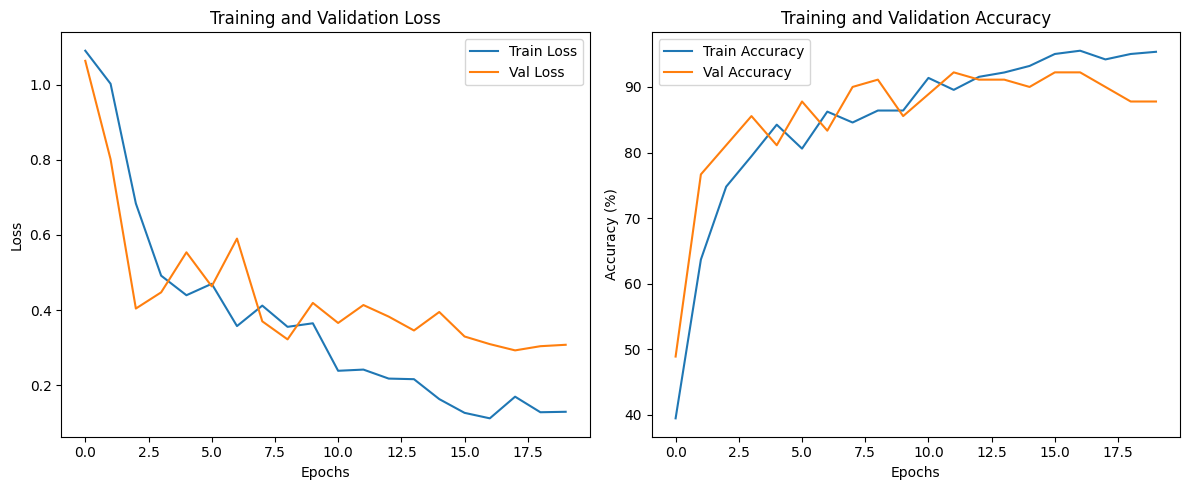

In [ ]:
# Plot training history
plt.figure(figsize=(12, 5))

# Convert accuracy values to percentages
train_accs = [acc.cpu().numpy() * 100 for acc in train_accs]
val_accs = [acc.cpu().numpy() * 100 for acc in val_accs]

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define streamlined hyperparameter grid
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'batch_size': [16, 32, 64],
    'epochs': [10],
    'dropout_rate': [0.1, 0.3, 0.5],
    'weight_decay': [0, 1e-5, 1e-4, 1e-3]
}

# Hyperparameter tuning loop with table logging and final evaluation
results = []
best_val_acc = 0.0
best_params = None
best_model_state = None

print("Starting Hyperparameter Tuning...")
for params in ParameterGrid(param_grid):
    print(f"\nTesting parameters: {params}")

    # Load dataset with current batch size
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=params['batch_size'], shuffle=True, num_workers=2),
        'val': DataLoader(image_datasets['val'], batch_size=params['batch_size'], shuffle=False, num_workers=2)
    }

    # Load and configure model
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=params['dropout_rate']),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(),
        nn.Linear(256, len(class_names))
    )
    model = model.to(device)

    # Define loss, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
    steps_per_epoch = len(dataloaders['train'])
    total_steps = steps_per_epoch * params['epochs']  # Adjust total steps based on epochs
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=params['learning_rate'], total_steps=total_steps)

    # Train the model (using the original train_model function)
    model, train_losses, train_accs, val_losses, val_accs = train_model(
        model, criterion, optimizer, scheduler, num_epochs=params['epochs']
    )

    # Extract training accuracy from the last epoch
    best_train_acc = train_accs[-1].item()

    # Final evaluation using the best saved model
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    final_val_acc = correct / total

    # Log results
    result = {
        'Learning Rate': params['learning_rate'],
        'Batch Size': params['batch_size'],
        'Epochs': params['epochs'],
        'Dropout Rate': params['dropout_rate'],
        'Weight Decay': params['weight_decay'],
        'Train Accuracy': best_train_acc,
        'Validation Accuracy': final_val_acc
    }
    results.append(result)

    # Track the best model
    if final_val_acc > best_val_acc:
        best_val_acc = final_val_acc
        best_params = params
        best_model_state = model.state_dict()
        torch.save(best_model_state, 'best_model_tuned.pth')

# Create and display results table
results_df = pd.DataFrame(results)
results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
print("\nHyperparameter Tuning Results:")
print(results_df)

# Output best results
print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Parameters: {best_params}")
print("Best model saved as 'best_model_tuned.pth'")

Starting Hyperparameter Tuning...

Testing parameters: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 10, 'learning_rate': 0.1, 'weight_decay': 0}
Epoch 1/10
Train Loss: 1.2654 Acc: 0.3698
Val Loss: 1651.0958 Acc: 0.3333

Epoch 2/10
Train Loss: 1.1233 Acc: 0.3499
Val Loss: 4.3127 Acc: 0.3667

Epoch 3/10
Train Loss: 1.1049 Acc: 0.3549
Val Loss: 1.1001 Acc: 0.3333

Epoch 4/10
Train Loss: 1.1065 Acc: 0.3134
Val Loss: 1.1000 Acc: 0.3333

Epoch 5/10
Train Loss: 19.8067 Acc: 0.3217
Val Loss: 740264.5361 Acc: 0.3444

Epoch 6/10
Train Loss: 1.1023 Acc: 0.3134
Val Loss: 1.1006 Acc: 0.3333

Epoch 7/10
Train Loss: 1.1073 Acc: 0.2886
Val Loss: 1.1001 Acc: 0.3333

Epoch 8/10
Train Loss: 1.1023 Acc: 0.3051
Val Loss: 1.0990 Acc: 0.3333

Epoch 9/10
Train Loss: 1.1017 Acc: 0.3300
Val Loss: 1.0994 Acc: 0.3333

Epoch 10/10
Train Loss: 1.0993 Acc: 0.3333
Val Loss: 1.0991 Acc: 0.3333


Testing parameters: {'batch_size': 16, 'dropout_rate': 0.1, 'epochs': 10, 'learning_rate': 0.1, 'weight_decay': 1e-05}
